In [1]:
# Import Libraries
import os
from distutils.file_util import copy_file
import glob
import cv2
import numpy as np
import pandas as pd
from sklearn import preprocessing
#from keras.utils import to_categorical

#from tensorflow.keras.applications import DenseNet201
from keras.applications import densenet
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, roc_curve

from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

import warnings
warnings.filterwarnings('ignore')

2024-03-14 08:53:58.418628: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 08:53:58.418785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 08:53:58.579874: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
pathtrain = '/kaggle/input/brain-tumor-mri-dataset/Training'
pathtest = '/kaggle/input/brain-tumor-mri-dataset/Testing'

In [3]:
# DATA PREPRCESSING
SIZE = 224 #images size
# Get training data and labels into respective lists
train_images = []
train_labels = [] 

for directory_path in glob.glob(pathtrain+"/*"):
    label = directory_path.split("\\")[-1] 
    #print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)
#Convert lists to numpy arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [4]:
# Get test data and labels into respective lists
test_images = []
test_labels = []
for directory_path in glob.glob(pathtest+"/*"):
    label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(label)
#Convert lists to numpy arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [5]:
print('Total Training Images: ', train_images.shape[0])
print('Total Test Images: ', test_images.shape[0])
print('Total Dataset Images: ', train_images.shape[0]+test_images.shape[0])

Total Training Images:  5712
Total Test Images:  1311
Total Dataset Images:  7023


In [6]:
train_labels

array(['/kaggle/input/brain-tumor-mri-dataset/Training/pituitary',
       '/kaggle/input/brain-tumor-mri-dataset/Training/pituitary',
       '/kaggle/input/brain-tumor-mri-dataset/Training/pituitary', ...,
       '/kaggle/input/brain-tumor-mri-dataset/Training/glioma',
       '/kaggle/input/brain-tumor-mri-dataset/Training/glioma',
       '/kaggle/input/brain-tumor-mri-dataset/Training/glioma'],
      dtype='<U57')

In [7]:
#Encode labels from text to integers.
label_encode = preprocessing.LabelEncoder()
label_encode.fit(test_labels)
test_labels_encoded = label_encode.transform(test_labels)
label_encode.fit(train_labels)
train_labels_encoded = label_encode.transform(train_labels)
print("Testing Data Length : ", len(test_labels_encoded))
print("Training Data Length : ", len(train_labels_encoded))

Testing Data Length :  1311
Training Data Length :  5712


In [8]:
# assigning train/test to meaningful convention
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [9]:
print("x_train length : ", len(x_train))
print("x_test length : ", len(x_test))
print("y_train length : ", len(y_train))
print("y_test length : ", len(y_test))


x_train length :  5712
x_test length :  1311
y_train length :  5712
y_test length :  1311


In [10]:

type(y_train)


numpy.ndarray

In [11]:
y_train.shape

(5712,)

In [12]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()

y_train_one_hot = lb.fit_transform(y_train)
y_test_one_hot = lb.fit_transform(y_test)

# y_train_one_hot = label_binarize(y_train, classes=[0, 1, 2, 4])
# y_test_one_hot = label_binarize(y_test, classes=[0, 1, 2, 4])
n_classes = y_train_one_hot.shape[1] 

# Evaluation

In [13]:
def evaluation_metrics(y_true, y_pred):
    print("Model Performance Evaluation:\n")
    accuracy = round(accuracy_score(y_true, y_pred) * 100, 2)
    precision = round(precision_score(y_true, y_pred,average='weighted') * 100, 2)
    f1Score = round(f1_score(y_true, y_pred, average='weighted') * 100, 2) 
    
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))

    
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
sns.set()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:

        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar() 
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes ,rotation=45)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.grid(color='w', linestyle='-')
    plt.tight_layout()
    
def ROC(n_classes, y_test_one_hot, prediction, title_text):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw=2
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], prediction[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(['blue', 'red', 'green', 'yellow'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title_text)
    plt.legend(loc="lower right")
    plt.savefig(title_text,dpi=300,bbox_inches='tight')
    #plt.show()
    

# **ResNet**

In [14]:
# Load RESNET model from keras applications
RESNET_model = densenet.DenseNet201(
    include_top = False,
    weights = 'imagenet',
    input_shape = (SIZE,SIZE,3),
    classifier_activation = 'sigmoid'
)

# make trainable parameters as False for 40 layers
# Freez first 40 layers and use last 10 layers in training on our own data
for i in range(40):           
  RESNET_model.layers[i].trainable = False

#RESNET_model.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [15]:
# Now extract features from RESNET network for SVM
RESNET_features_train = RESNET_model.predict(x_train)
X_train_RESNET = RESNET_features_train.reshape(RESNET_features_train.shape[0], -1)
print('Resnet Training Features: ', X_train_RESNET.shape)

RESNET_features_test = RESNET_model.predict(x_test)
X_test_RESNET = RESNET_features_test.reshape(RESNET_features_test.shape[0], -1)
print('Resnet Test Features: ', X_test_RESNET.shape)

179/179 ━━━━━━━━━━━━━━━━━━━━ 722s 4s/step
Resnet Training Features:  (5712, 94080)
41/41 ━━━━━━━━━━━━━━━━━━━━ 183s 4s/step
Resnet Test Features:  (1311, 94080)


# ***Concatenating Features Extracted for DenseNet201***

In [16]:
con_features = np.concatenate((X_train_RESNET, X_test_RESNET), axis=0)
print('Concatenated Features : ', con_features.shape)

Concatenated Features :  (7023, 94080)


# Applying PCA to Reduce the Dimentionality

In [17]:
from sklearn.decomposition import PCA

# Perform PCA with 4096 components
pca = PCA(n_components=4096)
pca.fit(con_features)

# Transform the data
transformed_data = pca.transform(con_features)
print(transformed_data.shape)

(7023, 4096)


In [18]:
x_train_pca = transformed_data[:5712,:]
x_test_pca = transformed_data[5712:,:]


print(len(x_train_pca))
print(len(x_test_pca))

5712
1311


In [19]:
x_train_pca_df= pd.DataFrame(data= x_train_pca)
x_test_pca_df= pd.DataFrame(data= x_test_pca)

In [20]:
x_train_pca.shape

(5712, 4096)

In [21]:
print(x_train_pca_df.shape)
print(x_test_pca_df.shape)

(5712, 4096)
(1311, 4096)


In [22]:
y_train_pca_labels_df= pd.DataFrame(y_train)
y_test_pca_labels_df= pd.DataFrame(y_test)

In [23]:
import pandas as pd
train = np.concatenate([x_train_pca_df, y_train_pca_labels_df], axis=1)
test = np.concatenate([x_test_pca_df, y_test_pca_labels_df], axis=1)

In [24]:
print(train.shape)
print(test.shape)

(5712, 4097)
(1311, 4097)


In [25]:
 
Train= pd.DataFrame(train)
Test= pd.DataFrame(test)

In [26]:
Train.tail()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
5707,-224.127396,27.717966,50.616608,48.586430,-9.174745,-60.280464,-48.197422,37.508820,48.852665,58.716900,...,-0.933173,-0.132814,0.854989,0.740593,1.029655,0.044579,-0.067428,-1.138368,0.463663,0.0
5708,-180.667999,-33.798420,99.668892,69.017036,-50.727867,95.738228,48.121162,121.652519,11.133942,4.407269,...,-1.314683,1.061110,0.981223,-0.352836,0.114966,-0.226001,0.154460,-1.097583,-1.425725,0.0
5709,-14.172542,-273.900726,52.604855,-40.597031,-251.881302,95.197044,-19.593555,115.137192,166.999863,-41.387058,...,0.425033,-1.008422,-1.158500,-1.317928,0.516218,0.681157,0.790145,-0.391576,-0.481156,0.0
5710,-287.638733,49.298759,186.719315,60.214161,27.117443,42.381927,94.700401,37.483425,-11.984167,49.139687,...,-2.147710,-0.315985,-0.322062,0.710052,0.240341,0.927704,0.008307,-0.850203,-0.848247,0.0
5711,69.517693,20.503717,-287.117889,236.795853,-39.751106,147.511505,-97.265205,-67.015038,-79.635155,-86.577293,...,0.164850,-0.483341,-0.241867,-0.518596,0.481195,0.136726,-0.614373,-0.317425,-1.269774,0.0


In [27]:
Train.tail()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
5707,-224.127396,27.717966,50.616608,48.586430,-9.174745,-60.280464,-48.197422,37.508820,48.852665,58.716900,...,-0.933173,-0.132814,0.854989,0.740593,1.029655,0.044579,-0.067428,-1.138368,0.463663,0.0
5708,-180.667999,-33.798420,99.668892,69.017036,-50.727867,95.738228,48.121162,121.652519,11.133942,4.407269,...,-1.314683,1.061110,0.981223,-0.352836,0.114966,-0.226001,0.154460,-1.097583,-1.425725,0.0
5709,-14.172542,-273.900726,52.604855,-40.597031,-251.881302,95.197044,-19.593555,115.137192,166.999863,-41.387058,...,0.425033,-1.008422,-1.158500,-1.317928,0.516218,0.681157,0.790145,-0.391576,-0.481156,0.0
5710,-287.638733,49.298759,186.719315,60.214161,27.117443,42.381927,94.700401,37.483425,-11.984167,49.139687,...,-2.147710,-0.315985,-0.322062,0.710052,0.240341,0.927704,0.008307,-0.850203,-0.848247,0.0
5711,69.517693,20.503717,-287.117889,236.795853,-39.751106,147.511505,-97.265205,-67.015038,-79.635155,-86.577293,...,0.164850,-0.483341,-0.241867,-0.518596,0.481195,0.136726,-0.614373,-0.317425,-1.269774,0.0


# Save Feature

In [28]:
from numpy import savetxt
savetxt('/kaggle/working/DenseNet201_train_features.csv', Train, delimiter=',')
savetxt('/kaggle/working/DenseNet201_test_features.csv', Test, delimiter=',')

In [29]:
classifier = OneVsRestClassifier(SVC(probability=True, kernel='linear'))
prediction_SVM_res_one_hot = classifier.fit(x_train_pca, y_train_pca_labels_df).decision_function(x_test_pca_df)
prediction_SVM_res = lb.inverse_transform(prediction_SVM_res_one_hot)

Model Performance Evaluation:

Accuracy  : 97.1
Precision : 97.08
f1Score : 97.09

Confusion matrix, without normalization
[[284  16   0   0]
 [ 10 285   9   2]
 [  0   1 404   0]
 [  0   0   0 300]]


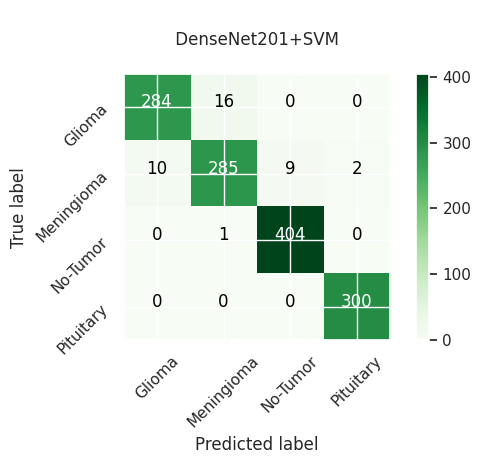

In [30]:
# Resnet Evaluation
evaluation_metrics(y_test, prediction_SVM_res)
print()
# Confusion Matrix
cm = confusion_matrix(y_test, prediction_SVM_res)
cm_plot_label =['Glioma', 'Meningioma', 'No-Tumor', 'Pituitary']
plot_confusion_matrix(cm, cm_plot_label, title ='\n DenseNet201+SVM \n')

# +(HOG+GLCM,LBP)
plt.savefig('DenseNet201+SVM',dpi=300,bbox_inches='tight')

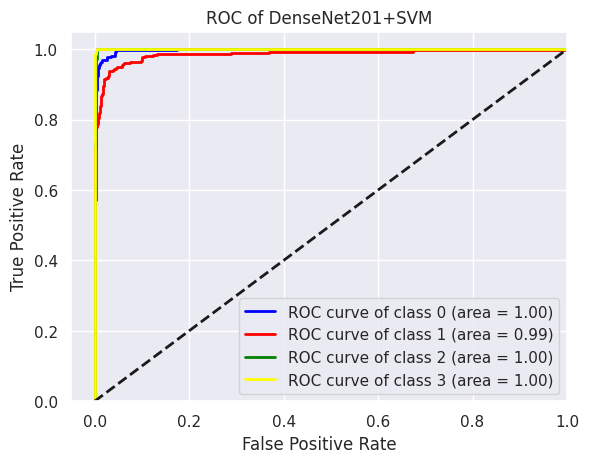

In [31]:
# Receiver operating characteristic of Resnet features classification
ROC(n_classes, y_test_one_hot, prediction_SVM_res_one_hot,'ROC of DenseNet201+SVM')

# **Gabor**

In [32]:
# Now get extracted features vector from our saved text files into list 
with open('/kaggle/input/gb-feayures/gb_features_train.txt') as file:
    gb_features_train = file.readlines()
gb_features_train = [x.strip() for x in gb_features_train] 

with open('/kaggle/input/gb-feayures/gb_features_test.txt') as file:
    gb_features_test = file.readlines()
gb_features_test = [x.strip() for x in gb_features_test]

X_train_gb =[]
for item in gb_features_train:
    mylist = item.split(',')
    X_train_gb.append(list(map(float, mylist)))

X_test_gb =[]
for item in gb_features_test:
    mylist = item.split(',')
    X_test_gb.append(list(map(float, mylist)))

# Convert into numpy array to feed in Machine learning model later
X_train_gb = np.array(X_train_gb)
X_test_gb = np.array(X_test_gb)
print('Gabor Training Features: ', X_train_gb.shape)
print('Gabor Test Features: ', X_test_gb.shape)

Gabor Training Features:  (5712, 32)
Gabor Test Features:  (1311, 32)


In [33]:
# # #Support Vector Machine Classifier
# SVM_model_gb = SVC(probability=True)

# # # Train classifier model on training data
# SVM_model_gb.fit(X_train_gb, y_train) #For sklearn no one hot encoding

# #Now predict using the trained SVM model
# prediction_SVM_gb = SVM_model_gb.predict(X_test_gb)

In [34]:
# Gabor
classifier = OneVsRestClassifier(SVC(kernel='poly',probability=True,random_state=0))
#prediction_SVM_gb_one_hot = classifier.fit(X_train_gb, y_train_one_hot).decision_function(X_test_gb)
prediction_SVM_gb_one_hot = classifier.fit(X_train_gb, y_train_pca_labels_df).decision_function(X_test_gb)
prediction_SVM_gb = lb.inverse_transform(prediction_SVM_gb_one_hot)

Model Performance Evaluation:

Accuracy  : 62.93
Precision : 58.25
f1Score : 56.27

Confusion matrix, without normalization
[[229  10   2  59]
 [116  10 108  72]
 [ 35   0 361   9]
 [ 61   6   8 225]]


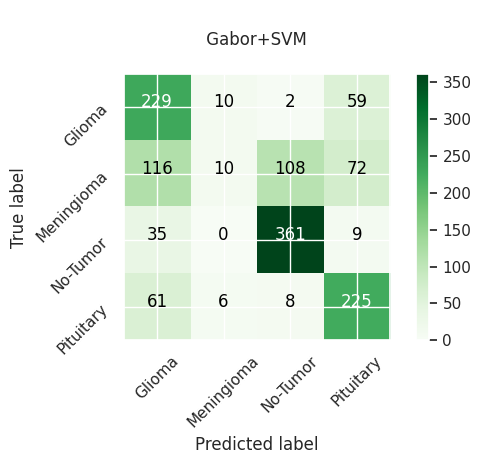

In [35]:
# Gabor Evaluation
evaluation_metrics(y_test, prediction_SVM_gb)
print()
# Confusion Matrix
cm = confusion_matrix(y_test, prediction_SVM_gb)
cm_plot_label =['Glioma', 'Meningioma', 'No-Tumor', 'Pituitary']
plot_confusion_matrix(cm, cm_plot_label, title ='\n Gabor+SVM \n')

# +(HOG+GLCM,LBP)
plt.savefig('Gabor+SVM',dpi=300,bbox_inches='tight')

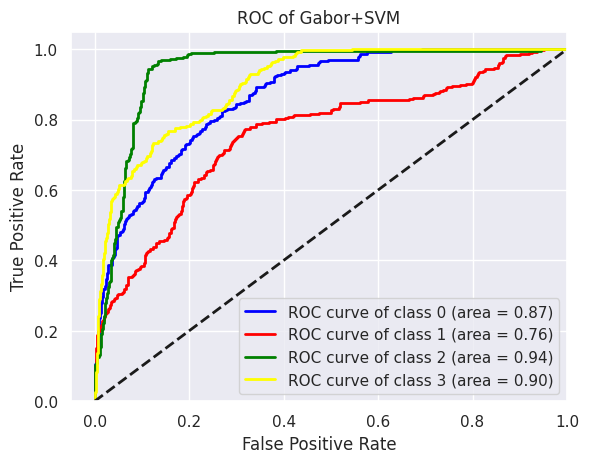

In [36]:
# Receiver operating characteristic of gabor features classification
ROC(n_classes, y_test_one_hot, prediction_SVM_gb_one_hot,'ROC of Gabor+SVM')

#  **Combine DenseNet201+Gabor+SVM**

In [37]:
# Combine both extracted features vectors from Gabor filter and from RESNET
X_train_combine = []
X_test_combine = []
for i in range(len(x_train)):
  Xt = np.concatenate((x_train_pca[i], X_train_gb[i]))
  X_train_combine.append(Xt)
for i in range(len(x_test)):
  Xt_ = np.concatenate((x_test_pca[i], X_test_gb[i]))
  X_test_combine.append(Xt_)

# Convert lists into numpy arrays
X_train_combine = np.array(X_train_combine)
X_test_combine = np.array(X_test_combine)
print('Combine Training Features: ', X_train_combine.shape)
print('Combine Test Features: ', X_test_combine.shape)

Combine Training Features:  (5712, 4128)
Combine Test Features:  (1311, 4128)


In [38]:
# # #Support Vector Machine Classifier
# SVM_model = SVC(probability=True)

# # # Train classifier model on training data
# SVM_model.fit(X_train_for_SVM, y_train) #For sklearn no one hot encoding
# #Now predict using the trained SVM model
# prediction_SVM = SVM_model.predict(X_test_for_SVM)

In [39]:
# combine ResNet50+Gabor
#classifier = OneVsRestClassifier(SVC(kernel='poly',probability=True,random_state=0))
#classifier = OneVsRestClassifier(SVC(probability=True, kernel='linear'))

classifier = OneVsRestClassifier(SVC(kernel= 'rbf', C=100))
prediction_SVM_combine_one_hot = classifier.fit(X_train_combine, y_train_one_hot).decision_function(X_test_combine)
prediction_SVM_combine = lb.inverse_transform(prediction_SVM_combine_one_hot)

Model Performance Evaluation:

Accuracy  : 98.09
Precision : 98.09
f1Score : 98.08

Confusion matrix, without normalization
[[291   9   0   0]
 [  6 291   7   2]
 [  0   0 405   0]
 [  0   1   0 299]]


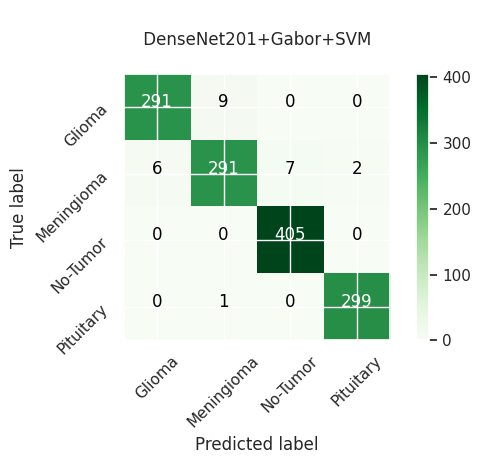

In [40]:
# combine ResNet50+Gabor Evaluation
evaluation_metrics(y_test, prediction_SVM_combine)
print()
# Confusion Matrix
cm = confusion_matrix(y_test, prediction_SVM_combine)
cm_plot_label =['Glioma', 'Meningioma', 'No-Tumor', 'Pituitary']
plot_confusion_matrix(cm, cm_plot_label, title ='\n DenseNet201+Gabor+SVM \n')

# +(HOG+GLCM,LBP)
plt.savefig('DenseNet201+Gabor+SVM',dpi=300,bbox_inches='tight')

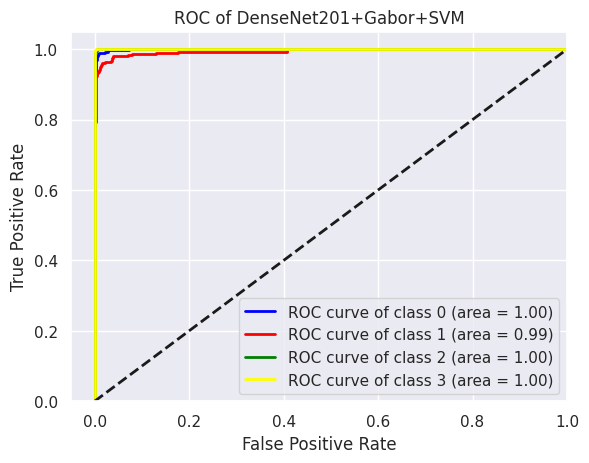

In [41]:
# Receiver operating characteristic of combine features classification
ROC(n_classes, y_test_one_hot, prediction_SVM_combine_one_hot,'ROC of DenseNet201+Gabor+SVM')

In [42]:
print('completed')

completed
